<a href="https://colab.research.google.com/github/mchenn3bula/ZhengyiChen/blob/master/Student_lab_7_and_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RDS Lab 7 and 8: DataSynthesizer

Today we will be talking about a privacy-preserving way to create synthetic data that (optionally) retains some useful characteristics of the original dataset. You can read about the DataSynthesizer in [Ping, Stoyanovich, and Howe (2017)](https://faculty.washington.edu/billhowe/publications/pdfs/ping17datasynthesizer.pdf). From the abstract:

> To facilitate collaboration over sensitive data, we present DataSynthesizer, a tool that takes a sensitive dataset as input and generates a structurally and statistically similar synthetic dataset with strong privacy guarantees. The data owners need not release their data, while potential collaborators can begin developing models and methods with some confidence that their results will work similarly on the real dataset.

We will cover three modes for generating synthetic data:
  1. random mode
  2. independent attribute mode
  3. correlated attribute mode

These modes are described in Ping, Stoyanovich, and Howe (2017, p.2):

> DataSynthesizer can operate in one of three modes: In correlated attribute mode, we learn a differentially private Bayesian network capturing the correlation structure between attributes, then draw samples from this model to construct the result dataset. In cases where the correlated attribute mode is too computationally expensive or when there is insufficient data to derive a reasonable model, one can use independent attribute mode. In this mode, a histogram is derived for each attribute, noise is added to the histogram to achieve differential privacy, and then samples are drawn for each attribute. Finally, for cases of extremely sensitive data, one can use random mode that simply generates type-consistent random values for each attribute.




In [1]:
# Install DataSynthesizer
!pip install DataSynthesizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import packages
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [3]:
# Intialize a describer and a generator from `DataSynthesizer`
describer = DataDescriber()
generator = DataGenerator()

## Preparation


In [4]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Download a file locally

fileid_compas = '1TDNwGAEwzqODunv-MkQvKNU2b_JgjzB2'    
sensitive_data_file = 'adult_reduced.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(sensitive_data_file)

In [6]:
# Read the downloaded file
real_data = pd.read_csv(sensitive_data_file)
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


Take a moment to familiarize yourself with the above data.

In [7]:
# Set up some local filepaths that we'll write to
description_files = {'random mode':                   'description(random).json', 
                     'independent attribute mode':    'description(independent).json', 
                     'correlated attribute mode':     'description(correlated).json'}
synthetic_data_files = {'random mode':                'synthetic data(random).csv', 
                        'independent attribute mode': 'synthetic data(independent).csv', 
                        'correlated attribute mode':  'synthetic data(correlated).csv'}

# Number of samples to generate?
output_data_size = 1000

# Random mode

In random mode, we replace the feature(s) that we want to protect with random values drawn from a uniform distribution:

In [8]:
# Learn from the data
describer.describe_dataset_in_random_mode(sensitive_data_file)

In [9]:
# Write the learned description into a file
describer.save_dataset_description_to_file(description_files['random mode'])

In the file browser on the left, we can open up `description(random).json` and see what kind of information was collected.

#### Important parameters when using random mode:

- __seed__: initializes the random number generator for both `random` and `np.random`
- __mininum__, __maximum__: determines the min and max of the random distribution from which we will draw the new values

## **TODO 1**: Set `minimum` and `maximum` to match the learned information about `age`, as seen in `description(random)`

In [10]:
generator.generate_dataset_in_random_mode(n=output_data_size, 
                                          description_file=description_files['random mode'], 
                                          seed=0, 
                                          minimum=0, 
                                          maximum=1000)

Now let's save the synthetic data, read it as a pandas dataframe, and look at the data:

In [11]:
# Write synthetic data to a file
generator.save_synthetic_data(synthetic_data_files['random mode'])
# Read that file
synthetic_random = pd.read_csv(synthetic_data_files['random mode'])
synthetic_random.head()

,age,education,sex,relationship,marital-status,income
0,684,Assoc-acdm,Female,Other-relative,Married-spouse-absent,>50K
1,559,9th,Male,Other-relative,Divorced,>50K
2,629,5th-6th,Female,Wife,Married-spouse-absent,>50K
3,192,Assoc-acdm,Male,Own-child,Widowed,<=50K
4,835,Bachelors,Female,Not-in-family,Married-civ-spouse,<=50K


In [36]:
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


## **TODO 2**: How do the values of the real and synthetic compare? Are there any obvious issues with the generated data? What kinds of information should we gather to avoid these issues?

**Answer:** the synthetic data does not follow the commom sense. For example, the age of the person can barely exceed 100 years old but the age in synthetic data are much higher.

## **TODO 3**: Make plots to compare the two dataframes above (the real data and synthetic data we just generated).
Look at the rows. How do the values of the real data and synthetic data compare?
- Make a histogram of the ages of people in the two dataframes.
- Make a bar plot of the relationship statuses in the two dataframes.

<Axes: xlabel='age', ylabel='Count'>

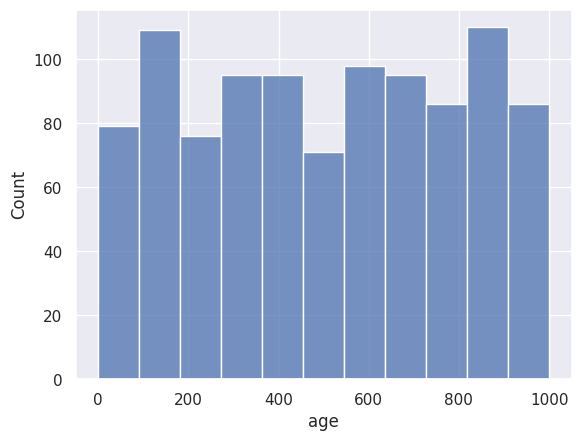

In [37]:
# Age histogram
import seaborn as sns
sns.histplot(data = synthetic_random, x = "age")


<Axes: xlabel='age', ylabel='Count'>

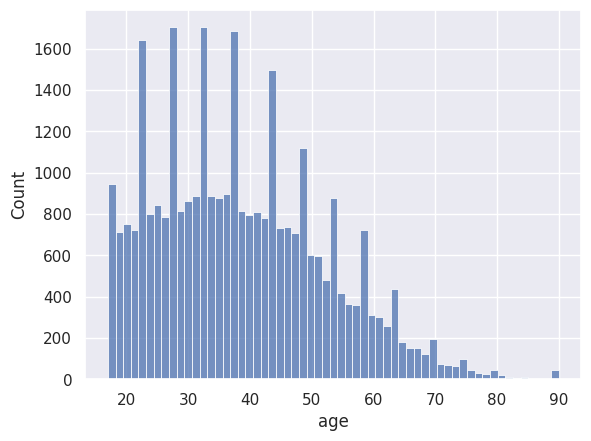

In [38]:
sns.histplot(data = real_data, x = "age")

<Axes: xlabel='relationship', ylabel='Count'>

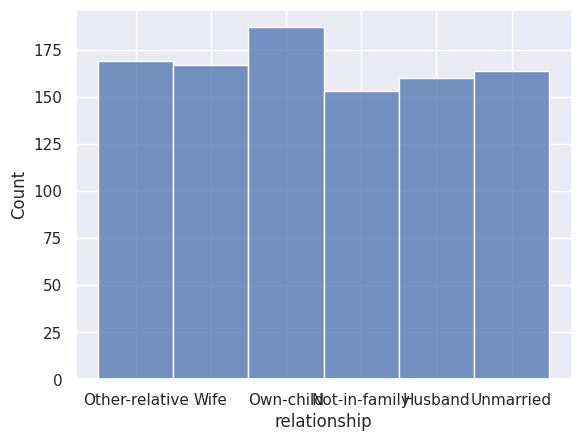

In [39]:
# Relationship bar plot
sns.histplot(data = synthetic_random, x = "relationship")

<Axes: xlabel='relationship', ylabel='Count'>

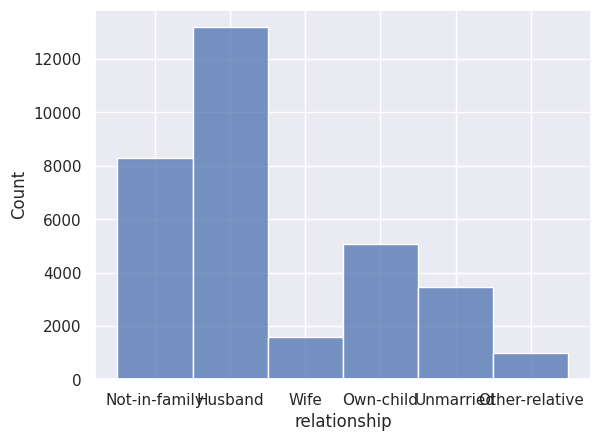

In [40]:
sns.histplot(data = real_data, x = "relationship")

We can also pull more information on how the relationship feature is generated in random mode using the describer functions. This is the same content as the `json` file we opened a moment ago, but now printed inline:

In [41]:
with open(description_files['random mode']) as f:
    description_json = json.load(f)

In [42]:
description_json.keys()

dict_keys(['meta', 'attribute_description'])

In [43]:
print(json.dumps(description_json['attribute_description']['relationship'], indent=4))

{
    "name": "relationship",
    "data_type": "String",
    "is_categorical": true,
    "is_candidate_key": false,
    "min": 4,
    "max": 14,
    "missing_rate": 0.0,
    "distribution_bins": [
        "Not-in-family",
        "Husband",
        "Wife",
        "Own-child",
        "Unmarried",
        "Other-relative"
    ],
    "distribution_probabilities": [
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666,
        0.16666666666666666
    ]
}


# Independent attribute mode

The histograms from the last section showed that we were generating data that was very much unlike the real data.
To resolve this issue, we now look at **independent attribute mode**.
In the last section, to generate data, we just generated data uniformly at random.
Here, we instead learn the distribution of each feature, and generate data by sampling from that distribution.
Vitally, in this section, we learn the distribution of each feature _independently_ of other features.
To make that concrete, when generating a fake person for our synthetic dataset, we generate their age and education level independnetly, so their age and education level might make no sense when studied together.

In [44]:
# Learn from the data
describer.describe_dataset_in_independent_attribute_mode(sensitive_data_file, epsilon=0.1)
# Write the learned description into a file
describer.save_dataset_description_to_file(description_files['independent attribute mode'])

## **TODO 4:**  Use ``generator.generate_dataset_in_independent_mode`` to generate synthetic data using the independent attribute mode.
Hint: Look at the ``generate_dataset_in_random_mode`` code above if you are unsure how to proceed. You should set a seed, but you do not need to set a minimum or maximum:

In [45]:
# generate synthetic data in independent attribute mode
# write your code here using: generator.generate_dataset_in_independent_mode
generator.generate_dataset_in_independent_mode(n=output_data_size, 
                                          description_file=description_files['independent attribute mode'], 
                                          seed=0)

In [46]:
# Write synthetic data to a file
generator.save_synthetic_data(synthetic_data_files['independent attribute mode'])
# Read that file
synthetic_independent = pd.read_csv(synthetic_data_files['independent attribute mode'])
synthetic_independent.head()

,age,education,sex,relationship,marital-status,income
0,42.0,HS-grad,Male,Not-in-family,Married-civ-spouse,<=50K
1,45.0,10th,Male,Not-in-family,Married-civ-spouse,<=50K
2,40.0,HS-grad,Male,Own-child,Divorced,<=50K
3,36.0,HS-grad,Female,Unmarried,Married-civ-spouse,<=50K
4,33.0,11th,Male,Own-child,Divorced,<=50K


Let's look at the distribution of relationship values in the real data and in the synthetic data generated using the independent attribute mode:

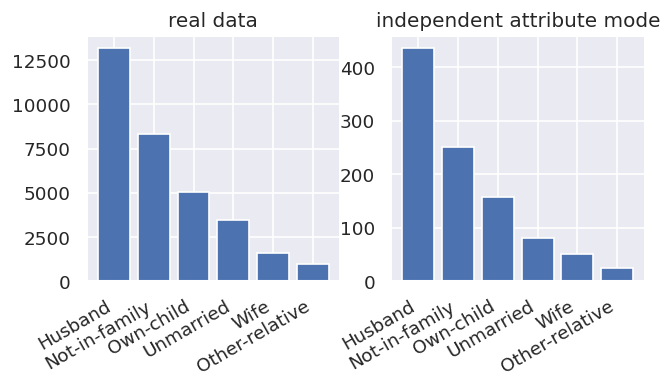

In [47]:
# @markdown
relationship_real = real_data['relationship'].value_counts()
relationship_independent = synthetic_independent['relationship'].value_counts()
relationship_both = pd.merge(relationship_real.to_frame(), 
                             relationship_independent.to_frame(), 
                             left_index=True, 
                             right_index=True, 
                             suffixes=('_real', '_independent_attribute_mode'))

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=120)
axes[0].bar(relationship_both.index, relationship_both['relationship_real'])
axes[1].bar(relationship_both.index, relationship_both['relationship_independent_attribute_mode'])
axes[0].set_title('real data')
axes[1].set_title('independent attribute mode')
fig.autofmt_xdate()

This seems a lot better now! We seem to have resolved the issue we saw from the uniformly random synthetic data.
Let's check that this is also true for age.

## **TODO 5:** Plot the distribution of age before and after being protected using independent attribute mode (i.e. in real_data and in synthetic_independent)

<Axes: xlabel='age', ylabel='Count'>

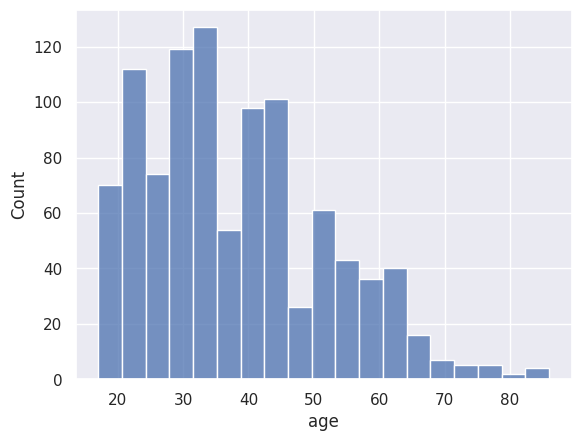

In [48]:
# Plot age before and after being protected using independent attribute mode
sns.histplot(data = synthetic_independent, x = "age")


<Axes: xlabel='age', ylabel='Count'>

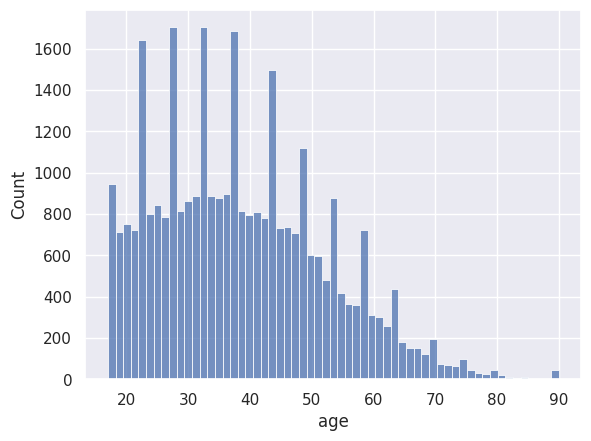

In [49]:
sns.histplot(data = real_data, x = "age")

Great, so we have better matched the histograms for real and synthetic data. Let's zoom into the data further.

## **TODO 6:** Plot the distribution of age for both low-income and high-income people.
That is, create 2 plots where one is for synthetic data and one is for real data. In each plot, draw two histograms, one for high-income people and one for low-income people.

Hint: `pandas` provides a useful command `groupby`, which will let you group the dataframe by income level, so you can pull the age out and plot that easily.
It's totally cool if you write a longer code; just mentioning a piece of code that can make this easier.

<Axes: xlabel='age', ylabel='Count'>

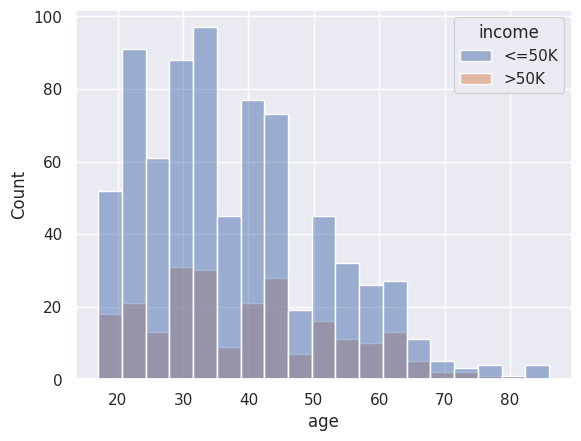

In [51]:
# Now plot the distribution of age by income group in the real data and in the synthetic data.
# Each plot should contain a histogram of age for all rows where income >50K and a histogram for age where income <=50k.
sns.histplot(data = synthetic_independent, x = "age", hue="income")

<Axes: xlabel='age', ylabel='Count'>

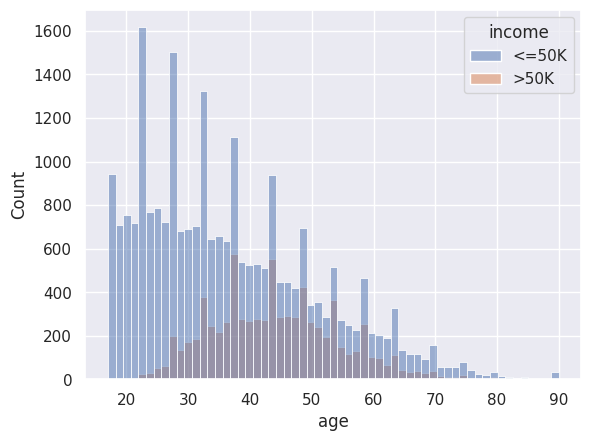

In [52]:
sns.histplot(data = real_data, x = "age", hue="income")

## **TODO 7:** How similar does our synthetic data look when compared to the real data? What does this reveal about the shortcomings of the independent random model? Most importantly, what sort of information should our model start taking into account to make our synthetic data's plot look more similar to the real data's plot?

**Answer:**We can see that the distribution of age of different income of the synthetic data is similar to the real data. The short come of the independent random model is that the data is generated independently, which will create the problems like people are making 50k+ at age of 18.


# Correlated attribute mode

We're going to tackle this innaccuracy we just found in the independent attributed mode by generating data in an even more refined way: we're going to learn conditional probabilities.
This is called the **Correlated Attribute Mode**.
Unfortunately, this comes with some downsides:
- It involves writing more code
- Since it learns more fine-grained information about our data, we have to add more noise to our synthetic data to maintain differential privacy. We have to make sure that generating data with these correlations does not reveal information about any individual in the training data.
- It's got a higher computational runtime.

For people familiar with machine learning lingo, we train a _Bayesian network_ on our real data, and generate a bunch of synthetic people by sampling from this Bayesian net.

In [55]:
# This trains a model to learn the correlations in the data
# We can already feel the slower runtime on our relatively small dataset
# For those who know Bayesian nets, k is the max number of parents any node in the Bayesian net can have

describer.describe_dataset_in_correlated_attribute_mode(sensitive_data_file, 
                                                        epsilon=0.1, 
                                                        k=2,
                                                        seed=0)

# Write this model/description to a file
describer.save_dataset_description_to_file(description_files['correlated attribute mode'])

================ Constructing Bayesian Network (BN) ================
Adding ROOT relationship
Adding attribute marital-status
Adding attribute sex
Adding attribute education
Adding attribute income
Adding attribute age
========================== BN constructed ==========================


The model has now learned some correlations.
In the code below, we can view the line
> `sex has parents ['marital-status', 'relationship'].`

as meaning that, in order to generate someone's `sex`, we will use their `marital-status` and their `relationship`.
These are the correlations that the model has learned:

In [56]:
# Display the correlations that our moded decided to learn
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    marital-status has parents ['relationship'].
    sex            has parents ['marital-status', 'relationship'].
    education      has parents ['sex', 'marital-status'].
    income         has parents ['marital-status', 'relationship'].
    age            has parents ['income', 'relationship'].


In [57]:
# @markdown We wrote (and hid) a bunch of code here that displays all the conditional probabilities we will use to generate someone's `education`. We can really see how many distinct numbers have to be learned to generate this synthetic dataset.

def get_domain_values(attribute_meta: dict):
    if attribute_meta['is_categorical']:
        return attribute_meta['distribution_bins']
    else:
        lefts = attribute_meta['distribution_bins']
        rights = attribute_meta['distribution_bins'][1:] + [attribute_meta['max']]
        lefts = [round(x, ndigits=3) for x in lefts]
        rights = [round(x, ndigits=3) for x in rights]
        return list(zip(lefts, rights))
    
def get_domain_entry(encoded_entry, attribute_meta):
    if attribute_meta['is_categorical']:
        return f"{attribute_meta['name']}={attribute_meta['distribution_bins'][encoded_entry]}"
    else:
        bins = attribute_meta['distribution_bins'] + [attribute_meta['max']]
        left_val = round(attribute_meta['distribution_bins'][encoded_entry], ndigits=3)
        right_val = round(attribute_meta['distribution_bins'][encoded_entry + 1], ndigits=3)
        return f"{attribute_meta['name']}=({left_val}, {right_val})"

def get_cpt(attribute: str, describer: DataDescriber):
    meta_of_all_attributes = describer.data_description['attribute_description']
    all_cpts = describer.data_description['conditional_probabilities']
    bn = dict(describer.data_description['bayesian_network'])

    attribute_meta = meta_of_all_attributes[attribute]
    cpt = pd.DataFrame(all_cpts[attribute]).transpose()
    cpt.columns = get_domain_values(attribute_meta)
    
    if attribute in bn:
        indices = []
        for idx_val in cpt.index:
            idx_val = eval(idx_val)
            if len(idx_val) == 1:
                conditions = get_domain_entry(idx_val[0], meta_of_all_attributes[bn[attribute][0]])
                indices.append(f'Pr({attribute} | {conditions})')
            else:
                entries = [get_domain_entry(val, meta_of_all_attributes[att]) for att, val in zip(bn[attribute], idx_val)]
                indices.append(f"Pr({attribute} | {', '.join(entries)})")
        
        cpt.index = indices
        return cpt
    else:
        cpt.index = [f'Pr({attribute})']
        return cpt

get_cpt('education', describer)

,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
"Pr(education | sex=Female, marital-status=Divorced)",0.076726,0.014741,0.017034,0.000000,0.019000,0.000000,0.000000,0.051908,0.000000,0.130735,0.000000,0.333752,0.035604,0.017457,0.078124,0.224919
"Pr(education | sex=Female, marital-status=Married-AF-spouse)",0.016731,0.020599,0.015803,0.000000,0.238863,0.000000,0.119507,0.054077,0.000000,0.102544,0.000000,0.155556,0.017961,0.145971,0.049232,0.063156
"Pr(education | sex=Female, marital-status=Married-civ-spouse)",0.019100,0.132031,0.027128,0.000000,0.021359,0.000000,0.000000,0.062048,0.028434,0.191237,0.004431,0.246443,0.041219,0.008660,0.024755,0.193156
"Pr(education | sex=Female, marital-status=Married-spouse-absent)",0.027480,0.027288,0.000000,0.097768,0.000000,0.000000,0.095118,0.063508,0.037815,0.000000,0.112961,0.081644,0.374878,0.000000,0.081541,0.000000
"Pr(education | sex=Female, marital-status=Never-married)",0.027949,0.025569,0.033619,0.016557,0.007670,0.003296,0.000000,0.037730,0.031919,0.171784,0.026363,0.276877,0.059165,0.000000,0.002009,0.279493
"Pr(education | sex=Female, marital-status=Separated)",0.000000,0.034452,0.000000,0.000000,0.000000,0.091855,0.000000,0.000000,0.201773,0.096491,0.000000,0.198521,0.039743,0.015804,0.000000,0.321362
"Pr(education | sex=Female, marital-status=Widowed)",0.052918,0.043568,0.024341,0.068503,0.000000,0.034919,0.000000,0.000000,0.228598,0.123711,0.002618,0.299197,0.000000,0.000000,0.000000,0.121627
"Pr(education | sex=Male, marital-status=Divorced)",0.041922,0.012893,0.000000,0.000000,0.000000,0.034094,0.009579,0.032978,0.093475,0.255747,0.000000,0.319314,0.012952,0.000000,0.041598,0.145447
"Pr(education | sex=Male, marital-status=Married-AF-spouse)",0.000000,0.020032,0.111830,0.030751,0.140965,0.000000,0.093440,0.000000,0.244535,0.051016,0.000000,0.238485,0.063837,0.000000,0.000000,0.005110
"Pr(education | sex=Male, marital-status=Married-civ-spouse)",0.006186,0.019608,0.007645,0.004086,0.011668,0.022786,0.017606,0.038412,0.037868,0.193990,0.012578,0.343646,0.068718,0.002225,0.024031,0.188947


Now let's actually generate some synthetic data.
## **TODO 8:** Use `generator.generate_dataset_in_correlated_attribute_mode` to generate synthetic data using the correlated attribute mode:

In [58]:
# generate synthetic data in correlated attribute mode
# write your code here using: generator.generate_dataset_in_correlated_attribute_mode
generator.generate_dataset_in_correlated_attribute_mode(n=output_data_size, 
                                          description_file=description_files['correlated attribute mode'], 
                                          seed=0)

Again, save the data and read it as a pandas dataframe:

In [59]:
# And we again save the data's description to a file locally
generator.save_synthetic_data(synthetic_data_files['correlated attribute mode'])
# Read that file
synthetic_correlated = pd.read_csv(synthetic_data_files['correlated attribute mode'])
synthetic_correlated.head()

,age,education,sex,relationship,marital-status,income
0,53.0,HS-grad,Male,Not-in-family,Divorced,<=50K
1,20.0,Some-college,Female,Own-child,Never-married,<=50K
2,40.0,Some-college,Male,Not-in-family,Divorced,<=50K
3,47.0,HS-grad,Female,Not-in-family,Divorced,<=50K
4,44.0,5th-6th,Female,Not-in-family,Married-AF-spouse,<=50K


Let's look at the distribution of relationship values in the real data, in the synthetic data generated using the independent attribute mode, and in the synthetic data generated using the correlated attribute mode:

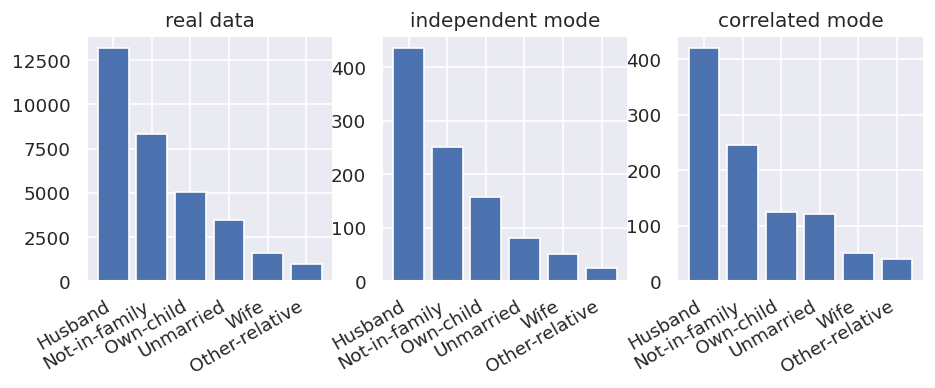

In [60]:
# plot the distribution of "relationship" in the synthetic data generated under the correlated attribute mode and the independent attribute mode here

relationship_real = real_data['relationship'].value_counts()
relationship_correlated = synthetic_correlated['relationship'].value_counts()
relationship_independent = synthetic_independent['relationship'].value_counts()
relationship_both = pd.merge(relationship_real.to_frame(), 
                             relationship_correlated.to_frame(), 
                             left_index=True, 
                             right_index=True, 
                             suffixes=('_real', '_correlated_attribute_mode'))
relationship_all = pd.merge(relationship_both, 
                            relationship_independent.to_frame(), 
                            left_index=True, 
                            right_index=True)

fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=120)
axes[0].bar(relationship_all.index, relationship_all['relationship_real'])
axes[1].bar(relationship_all.index, relationship_all['relationship'])  # This is the independent mode
axes[2].bar(relationship_all.index, relationship_all['relationship_correlated_attribute_mode'])
axes[0].set_title('real data')
axes[1].set_title('independent mode')
axes[2].set_title('correlated mode')
fig.autofmt_xdate()

## **TODO 9:** Plot the distribution of age in the real data, synthetic data from the independent attribute mode, and synthetic data from the correlated attribute mode:

<Axes: xlabel='age', ylabel='Count'>

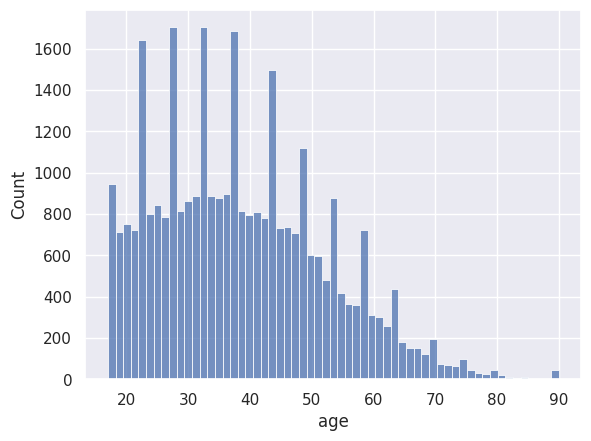

In [61]:
# plot the distribution of age in the real data and synthetic_independent and synthetic_correlated
sns.histplot(data = real_data, x = "age")

<Axes: xlabel='age', ylabel='Count'>

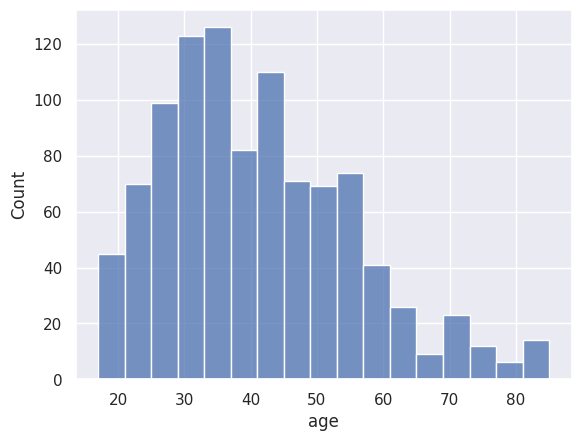

In [62]:
sns.histplot(data = synthetic_correlated, x = "age")

<Axes: xlabel='age', ylabel='Count'>

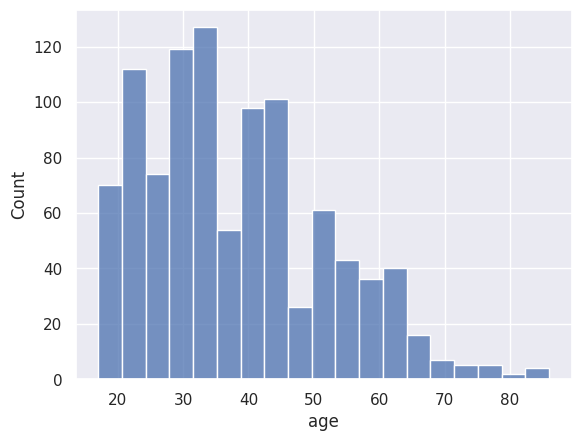

In [63]:
sns.histplot(data = synthetic_independent, x = "age")

Eh, this seems like a mixed bag. We have somewhat matched the histograms for the correlated and real data, but not as well as the independent data. Next, let's zoom into the data again.

## **TODO 10:** Plot the distribution of age for both low-income and high-income people.

That is, create 3 plots where one is for real data, one is for synthetic independent data, and one is for synthetic correlated data. In each plot, draw two histograms, one for high-income people and one for low-income people.

<Axes: xlabel='age', ylabel='Count'>

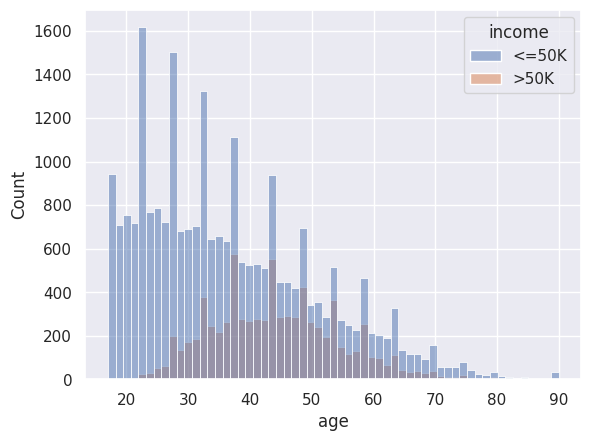

In [65]:
# write code here to plot the distribution of one variable by another variable
# in the real data and in synthetic_correlated
sns.histplot(data = real_data, x = "age", hue="income")



<Axes: xlabel='age', ylabel='Count'>

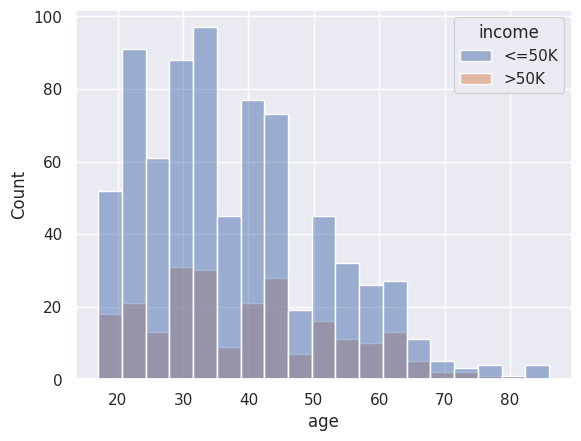

In [66]:
sns.histplot(data = synthetic_independent, x = "age", hue="income")

<Axes: xlabel='age', ylabel='Count'>

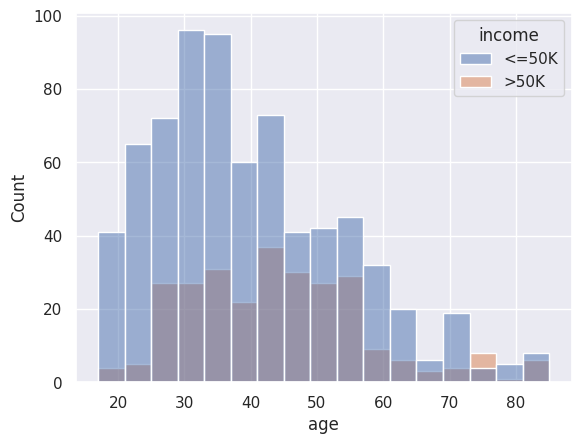

In [67]:
sns.histplot(data = synthetic_correlated, x = "age", hue="income")

## **TODO 11:** Which model does a better job of preserving correlations while maintaining differential privacy?

**Answer:** the correlated model does a better job of preserving correlations while maintaining differential privacy

# Statistical measures

Now let's try to put some numbers to how in-accurate these models are.
There's a few different ways to do this which we will explore.

### Mutual information

**Mutual Information** measures how dependent two random variables are. Suppose $X$ and $Y$ are two (possibly dependent) random variables.
We can imagine two different ways to generate a pair $(X,Y)$:
- We sample some $X$, and then sample some $Y$ in a way that depends on $X$, taking that conditional probability into account.
- We sample some $X$ and some $Y$ independently.

If $X$ and $Y$ are independent, then these two methods are identical.
If $X$ and $Y$ are perfectly correlated, then these two methods are extremely different.
Mutual Information measures this difference, and is defined as:
$$I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log(\frac{p(x,y)}{p(x)p(y)})$$

If $X$ and $Y$ are independent, then $p(x,y) = p(x) p(y)$ and so $\log(\frac{p(x,y)}{p(x)p(y)}) = \log(1) = 0$, so the mutual information is zero.
Otherwise, the mutual information is positive.


Conveniantly, mutual information is well defined for both categorical and continous variables.
For a continuous variable, we just replace the sum with an integral.

The definition of mutual information is pretty opaque as we have written it, but the metric has a super deep meaning in the fields of _Information Theory_ and _Statistics_.
Because it is always well defined, and because of this deep meaning, mutual information has been consistently used in machine learning as a way to measure how far from independent variables are.

We will also look at **Normalized Mutual Information**, which is just mutual information that has been scaled so that:
- If the normalized mutual information = 0, then $X$ and $Y$ are independent
- If the normalized mutual information = 1, then $X$ and $Y$ are perfectly correlated

There's some technical nuance to how this normalization is computed actually. If you're curious, check out [Section 2.3.10.2 from the scikit-learn docs](https://scikit-learn.org/stable/modules/clustering.html#mutual-info-score).

In [68]:
from sklearn.metrics import normalized_mutual_info_score

In [69]:
# Definitely not independent
normalized_mutual_info_score(real_data['marital-status'], 
                             real_data['relationship'], 
                             average_method='arithmetic')

0.5249037668258572

In [70]:
# Close-ish to independent
normalized_mutual_info_score(real_data['marital-status'], 
                             real_data['education'], 
                             average_method='arithmetic')

0.014483450445067415

We can plot the normalized mutual information between all pairs of features in the dataset.
First, we compare **real data** and **synthetic correlated data**.

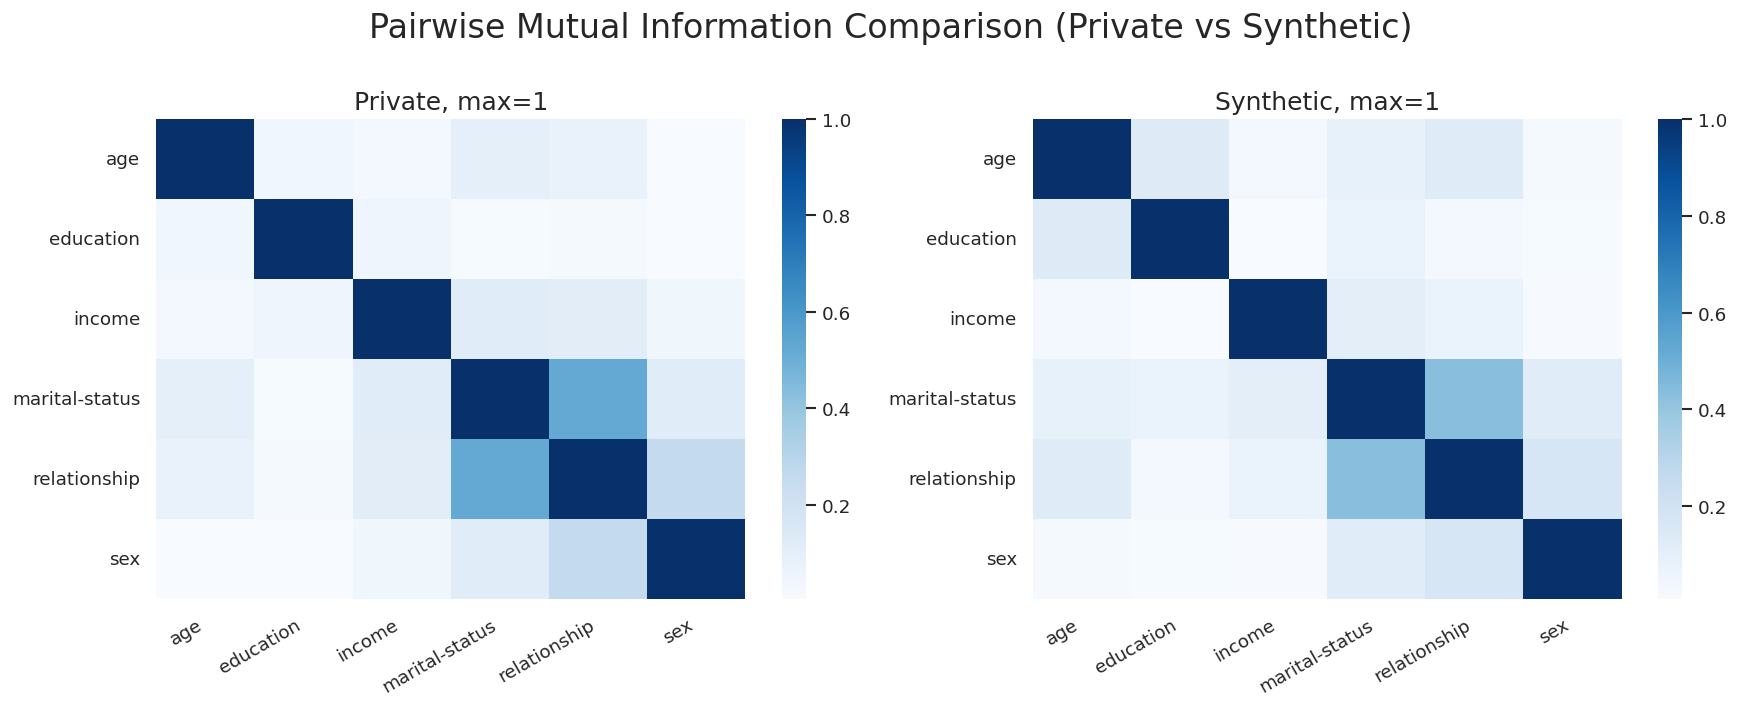

In [71]:
attribute_description = read_json_file(description_files['correlated attribute mode'])['attribute_description']
ModelInspector(real_data, 
               synthetic_correlated, 
               attribute_description).mutual_information_heatmap()

Next, we compare **real data** and **synthetic independent data**.

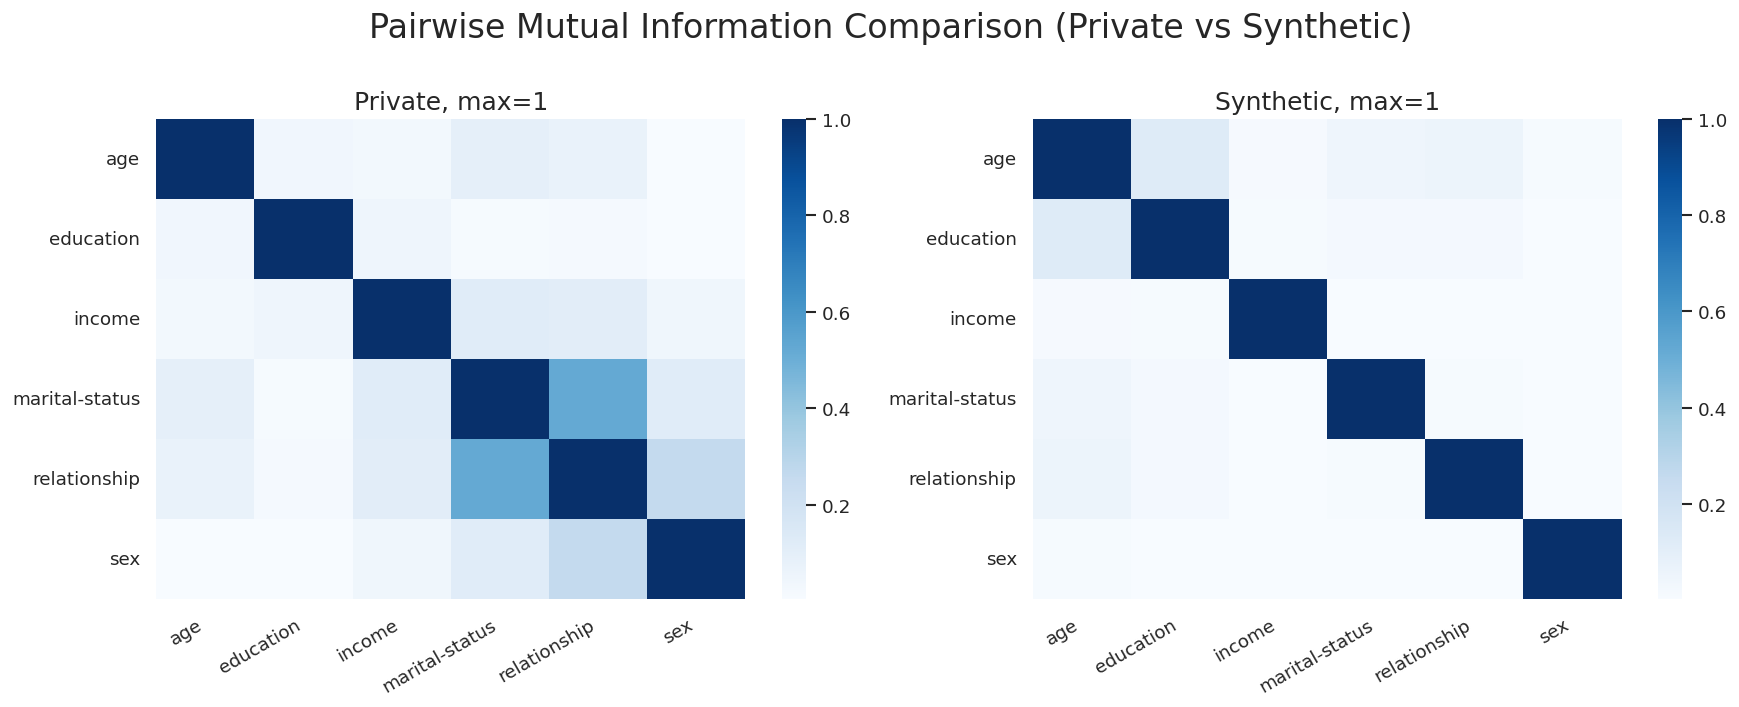

In [72]:
attribute_description = read_json_file(description_files['independent attribute mode'])['attribute_description']
ModelInspector(real_data, 
               synthetic_independent, 
               attribute_description).mutual_information_heatmap()

## Two-sample Kolmogorov–Smirnov test

The **Kolmogorov-Smirnov statistic** is one way to measures how similar two distributions are.
Suppose $X$ and $Y$ are two continuous random numbers, like $X$ is the age of a random person in the real data, and $Y$ is the age of a random person in the synthetic data.
We could looks at the CDF of these random variables.
If $X$ and $Y$ have the exact same distribution (our synthetic data is perfect), then the two CDF functions will always equal each other.
Otherwise, if they're not the exact same, then the CDFs will also be different.
The Kolmogorov-Smirnov statistic computes the biggest gap between the CDFs

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cf/KS_Example.png">

In the above picture, imagine the red curve is the CDF of the real age of a person and the blue curve is the CDF of the ages we synthetically generate.
Then the Kolmogorov-Smirnov Statistic is equal to the height of the black line -- the biggest gap between the two functions.

This metric also has a rich history in statistics, and can be generalized to consider vectors of real numbers, but cannot cover categorical variables. It can be used to run the **Kolmogorov-Smirnov Test**, which is a formal statistical test of whether or not two distributions are the same/extremely similar.

In [73]:
from scipy.stats import ks_2samp

In [74]:
# Returns the p-value for the KS-test.
# Remember: small p value means you reject the null hypothesis -- you have evidence that the two distributions are *different*
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[1]

In [75]:
# Really small -- these distributions are different
ks_test(real_data, synthetic_random, 'age')

0.0

In [76]:
# Really big -- these distributions are nearly the same
ks_test(real_data, synthetic_independent, 'age')

0.02902321565436905

In [77]:
# Kinda small -- these distributions are borderline similar; you could take this either way.
ks_test(real_data, synthetic_correlated, 'age')

0.0008873191982118708

## KL-divergence

The KL-divergence is an alternative way to measure the difference between two distributions.
For two distributions P and Q, the KL-divergence is

$$D = \sum_x P(x) \log (\frac{P(x)}{Q(x)})$$

This metric works on both continuous and discrete/categorical variables.
Once again, this metric has a rich history in statistics and information theory, which motivates using it in situations like this one.

Importantly, the KL-Divergence is not symmetric: the divergence from $P$ to $Q$ is not equal to the divergence from $Q$ to $P$.
In practice, it often doesn't matter which is which, but it's worthwhile to try to remain consistent with which random variables goes where.
We will take $P$ to be the real data distribution, and $Q$ to be synthetic.

The KL divergence can be any positive number; it does not have to be between 0 and 1.

In [79]:
from scipy.stats import entropy

In [78]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [80]:
# Big, I guess?
kl_test(real_data, synthetic_random, 'relationship')

0.3784000579893456

In [81]:
# Pretty small
kl_test(real_data, synthetic_independent, 'relationship')

0.004852757128718812

In [82]:
# Pretty small
kl_test(real_data, synthetic_correlated, 'relationship')

0.0062997091819315945

### Boxplot

It is often useful to the compare distributions of a continuous variable using a boxplot. For example, we plot the distribution of age by income status in the real data and in the synthetic_correlated data below:

In [83]:
import seaborn as sns

In [84]:
real_data.head()

,age,education,sex,relationship,marital-status,income
0,39,Bachelors,Male,Not-in-family,Never-married,<=50K
1,50,Bachelors,Male,Husband,Married-civ-spouse,<=50K
2,38,HS-grad,Male,Not-in-family,Divorced,<=50K
3,53,11th,Male,Husband,Married-civ-spouse,<=50K
4,28,Bachelors,Female,Wife,Married-civ-spouse,<=50K


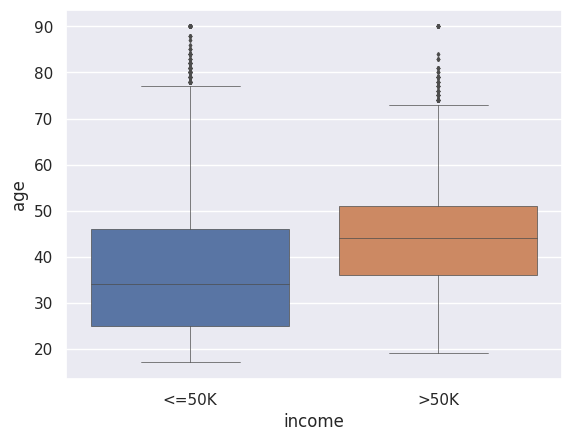

In [85]:
plt.figure(dpi=100)
sns.boxplot(x='income', y='age', data=real_data, linewidth=0.5, fliersize=2);

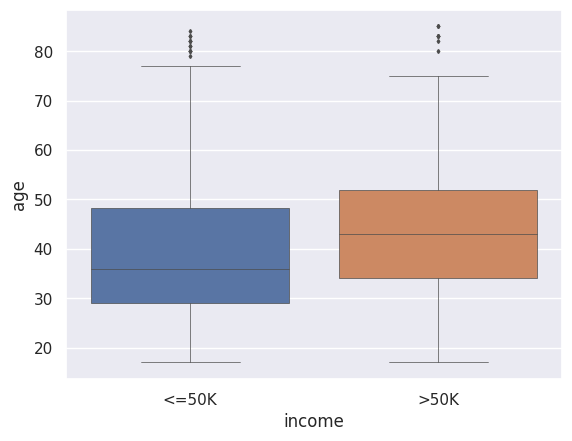

In [86]:
plt.figure(dpi=100)
sns.boxplot(x='income', y='age', data=synthetic_correlated, linewidth=0.5, fliersize=2);